# **Stage 2 - Deep Reinforcement Learning for Infinite Impulse Response (IIR) Filter Implementation - part 4** 

## Scope - *analyzing alternative reward functions and multi-layer DDPG agents*
References:- Chapter 11 of *Digital Signal Processing: signals, systems, and filters* by *Andreas Antoniou*

- In the previous stage, we figured out that the reward function we have been using so far does not result in learning the optimal filters due to its inability to compensate or neglect the phase distortions of IIR filtering. (see 'notebook-stage_2.3.1.ipynb')
- Therefore, we have to discuss about some **alternative reward functions that do not consider phase changes (time delays) in the signals when evaluating a filter**; one such reward function was defined in the previous notebook, `freq_domain_SNR`, which calculates SNR considering the magnitude spectrums of the target and filtered signals. However, this reward function did not result in learning optimal filters as expected. 
- There are enough reasons to believe that this new reward function is indeed capable of learning optimal filters since *the assumed best ideal counterparts of the learned filters result in better testing reward curves*. But, for some reason, a DDPG model with this reward function does not learn those optimal solutions; one main reason can be non-optimized hyperparameters of the model. 
- Also, ***for multicarrier interference situations***, the learning performance is in a seriously poor level. 
- One solution for this can be **changing the learning capability of the DDPG agent by increasing its number of layers**. Up to this point, the `DDPGagent` only allowed the width of the model to change while the depth of the two networks were fixed at 2. Now, we will try increasing the depth of the networks and see the resulting learning performances. 
 

In [1]:
import os, sys, json, time, copy
from typing import Callable
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.io import wavfile
from scipy.fft import irfft, rfft, fftshift, fftfreq
from scipy.signal import lfilter, zpk2tf, freqz

import tensorflow as tf 
import tensorflow.keras as keras

import gymnasium as gym
from gymnasium import spaces

sys.path.append('../')
from stage1_helper import SNR, Spectrum, apply_filter
from stage2_helper import create_target_and_jammed_signals, train, test, polar2cmplx, NormalizeState
from stage2_helper import linear, tan_mapping, scaled_linear_mapping, conditional_linear, rational_mapping, parameterized_rational_mapping
from DDPG import DDPGAgent

2024-01-14 11:34:47.997970: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 11:34:48.136223: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 11:34:48.136403: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-14 11:34:48.137728: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-14 11:34:48.190514: I tensorflow/core/platform/cpu_feature_g

In [2]:
# DEFINE CONSTANTS
S = 100 # state size (length of the state audio sample sequence)
SAMPLING_FREQ = 44_100 # Hz
CUT_OFF_FREQ = 5_000 # Hz
INTERFERENCE_CENTER_FREQ = 15_000 # Hz
EPS = 1e-6

### **Alternative Reward Functions for Multicarrier Interference**

- For multicarrier interference, let's try out following basic reward functions. 
> - ``SNR`` (time-domain SNR; the reward function used so far)
> - `freq_domain_SNR` (frequency-domain SNR based on magnitude spectrums of the target and filtered signals)

In [6]:
# receiver environment with IIR filtering and new SNR reward function in Frequency Domain 
class ReceiverEnvWithArbitaryOrderIIRandNewSNR(gym.Env):
    """
    A custom environment developed in the accordance with gym environment API that immitates a receiver of jammed audio with IIR filtering. 
    :param order: the order of the filter 
    :param S: signal partition size which represents a state 
    :param cut_off_freq: the frequency to truncate the audio spectrum to generate the target signal; equivalent to the ideal cut-off frequency of the learned filter
    :param interference_center_freq: the frequency/frequencies to shift the target spectrum to generate the non-overlapping interference
    :param interference_scalar: scaling factors to scale the shifted interference spectrums; default is 1
    :param zero_magnitude_mapping: a callable function to convert the values of actions for the magnitude of zeros from range [0, 1] to [0, inf); \
        the function must take a float in the range [0, 1] as the input and return a float in the range [0, inf); \
        default mapping is linear (no mapping)
    :param gradient: the gradient argument for the ``zero_magnitude_mapping`` function; represents the gradient of the function around the middle point of the input domain (x=0.5), \
        which corresponds to the unit circle; default is None, indicating no gradient argument is required in ``zero_magnitude_mapping``
    :param fix_zeros_magnitude: a boolean value specifying to fix the magnitudes of zeros to 1 (useful to reduce the dimensionality of the action space); \
        default is False
    :param automatic_gain: a boolean value to automatically estimate the constant gain factor 'k' of the filter so that the filter gain becomes unity at zero frequency \
        (useful to reduce the dimensionality of the action space); default is False
    :param show_effect: a boolean value specifying whether to show the reward and action of each step; default is True
    :param audio_json: path of a json file containing the names of the audio wav files the environment can access\
        put the audio file names without the .wav extension in a json array inside the file
    """

    # define constants 
    MIN_BUFFER_SIZE = 10 # RAISE THIS LATER!!!
    EPISODE_LENGTH  = np.inf # np.inf
    MAX_TOTAL_NUM_OF_STEPS = np.inf
    # OBSERVATION_SPACE_BOUND = 5

    def __init__(self,
                 order: int,
                 S: int, 
                 cut_off_freq: int, 
                 interference_center_freq: int | float | list[int | float], 
                 interference_scalar: int | float | list[int | float],
                 zero_magnitude_mapping: Callable[[float], float] = linear,
                 gradient: float | int = None,
                 fix_zeros_magnitude: bool = False,
                 automatic_gain: bool = False,
                 show_effect: bool = True,
                 audio_json: str = '../stage_1/audio_files/audio_files.json'
        ):

        super(ReceiverEnvWithArbitaryOrderIIRandNewSNR, self).__init__()

        # ----- verifying input arguments and setting them as class atributes ----
        # filter order
        if type(order) != int or order < 2:
            raise Exception(f"the filter order must be a positive integer greater than 2: given {order}")
        self.order = order

        # signal partition size
        if S < self.MIN_BUFFER_SIZE:
            raise Exception(f"the buffer size 'S' must be larger than MIN_BUFFER_SIZE, {self.MIN_BUFFER_SIZE}: given {S}")
        self.S = S

        # other parameters
        self.cut_off_freq = cut_off_freq
        self.interference_center_freq = interference_center_freq
        self.interference_scalar = interference_scalar
        self.audio_json = audio_json
        self.show_effect = show_effect
        self.zero_magnitude_mapping = zero_magnitude_mapping
        self.gradient = gradient
        self.fix_zeros_magnitude = fix_zeros_magnitude
        self.automatic_gain = automatic_gain

        # ----------------------------- Action Space -----------------------------
        # action - choosing fixed gain k, zeros, and poles of an N-th order IIR filter
        # note that the action is NOT TUNING/,ADJUSTING, or CHANGING the coefficeints of an existing filter. 
        # the dimensionality of the action space depends on whether the filter order is even or not and the two arguments `fix_zeros_magnitude` and `automatic_gain`
        if order % 2 == 0:
            action_shape = 2*order + 1
            if (fix_zeros_magnitude):
                action_shape -= order//2 # N/2 number of actions get fixed
            if (automatic_gain):
                action_shape -= 1 # the constant gain 'k' becomes fixed
        else:
            raise Exception(f"the environment still does not support odd order IIR filters: given {order}")
        print(f"creating action space with {action_shape} dimensions...")
        self.action_space = spaces.Box(low=0, high=1, shape=[action_shape], dtype=np.float32) # float16 -> float32, lower limit must be 0. 

        # ----------------------------- State Space ------------------------------
        state_shape = (self.S, )
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=state_shape, dtype=np.float64)

        # ------------------------------ Counters --------------------------------
        self.global_counter = 0  # a counter to keep track of the number of elapsed time steps of the environment
        self.counter = 0         # a counter to keep track of the number of elapsed time steps in the current episode
        self.episode_counter = 0 # a counter to keep track of the number of total episodes

    def reset(self, seed=None, options=None):

        super().reset(seed=seed, options=None) # options must be forced to None
        
        # reset the counters
        if isinstance(options, dict) and 'reset_all' in options and options['reset_all'] == True:
            self.global_counter  = 0
            self.episode_counter = 0
        self.counter = 0
        self.episode_counter += 1

        print('\n' + "-" * 50 + f"episode no: {self.episode_counter}" + "-" * 50)

        # for each episode, choose the audio signal specified by `audio_num` in the options
        with open(self.audio_json) as audio_json_file:
            train_audio_names = json.load(audio_json_file)["train"]
        audio_num = 1 # default audio track - 'arms_around_you-MONO.wav'
        if isinstance(options, dict) and 'audio_num' in options:
            audio_num = options['audio_num']
        
        # i = np.random.randint(low=1, high=self.audio_num) # len(train_audio_names)
        # create the target and jammed signals
        target_signal, jammed_signal = create_target_and_jammed_signals(
            audio_name = train_audio_names[audio_num], 
            truncation_freq = self.cut_off_freq, 
            interference_center_freq = self.interference_center_freq,
            interference_scalar = self.interference_scalar,
            signal_partition_size = self.S
        )
        self.target_signal = target_signal
        self.jammed_signal = jammed_signal

        # create another internal state
        self.internal_state = jammed_signal[:self.S]

        # return the initial state 
        self.state = NormalizeState(self.internal_state)

        # declare the initial conditions in the start of the audio
        self.initial_conds = np.zeros(self.order)

        info = {}

        # return the initial state and info
        return self.state, info

    def step(self, action):

        # increment the counters
        self.global_counter += 1
        self.counter += 1

        # ----- create the filter -----
        if self.order % 2 == 0:
            shift = self.order // 2
            zs = []; ps = [][:]
            for i in range(self.order // 2):
                # extract the zero, pole, and gain
                if (self.fix_zeros_magnitude):
                    z = polar2cmplx(1, np.pi * action[i])
                    p = polar2cmplx(action[i + shift], np.pi * action[i + 2*shift])
                elif self.gradient == None:
                    # zero magnitude mapping function does not required a gradient argument 
                    z = polar2cmplx(action[i], np.pi * action[i + shift]) # self.zero_magnitude_mapping(
                    p = polar2cmplx(action[i + 2*shift], np.pi * action[i + 3*shift])
                else:
                    z = polar2cmplx(self.zero_magnitude_mapping(action[i], self.gradient), np.pi * action[i + shift])
                    p = polar2cmplx(action[i + 2*shift], np.pi * action[i + 3*shift])

                zs += [z, np.conjugate(z)] # array of zeros of TF
                ps += [p, np.conjugate(p)] # array of poles of TF
        
        else:
            raise Exception(f"the environment still does not support odd order IIR filters: given {self.order}")

        # find the transfer function of the filter with UNITY GAIN
        b, a = zpk2tf(zs, ps, 1)

        if (self.automatic_gain):
            # estimate k
            k = 1/(freqz(b, a, worN=[0], fs=SAMPLING_FREQ)[0] + EPS)
        else:
            k = action[-1]
        b *= k

        # get signal partition from the buffer (internal state)
        partition = self.internal_state

        # generating the next state
        terminated = False
        if self.S * (self.counter + 1) >= len(self.jammed_signal):
            terminated = True
        else:
            self.internal_state = self.jammed_signal[self.S * self.counter : self.S * (self.counter + 1)]
            self.state = NormalizeState(self.internal_state)
        
        # apply the IIR filter to the current state and set the initial conditions for the next state
        filtered, self.initial_conds = lfilter(b, a, partition, zi=self.initial_conds)
        target = self.target_signal[self.S * (self.counter - 1) : self.S * self.counter]

        # calculate the reward (SNR)
        reward = SNR(target, filtered)
        if np.isnan(reward):
            print(f"step: {self.counter} - reward value is not a number... \nk: {k}, filter: {filter}; assigning -20dB as the reward...")
            reward = -20 # assign a very large negative reward
            # raise Exception(f"reward value is not a number...\ntarget: {target}\nfiltered: {filtered}\nfilter: {filter}")
        
        # if self.counter % 50 == 1:
        if self.show_effect: print(f"step: {self.counter}, SNR: {reward}, filter: {k}, {b}, {a}")
        
        # truncating the episode
        truncated = False
        if self.episode_counter == self.EPISODE_LENGTH or self.global_counter == self.MAX_TOTAL_NUM_OF_STEPS:
            truncated = True
        
        info = {} 

        return self.state, reward, terminated, truncated, info

    def render(self):
        pass

    def close(self):
        pass

audio name: 'this_is_me_trying-MONO'
sampling rate: 44100 Hz
audio shape: (8837504,)
data type: int16
MONO audio file...
generating the target signal...
	truncating the spectrum at 5000Hz
	converting from float64 to <class 'numpy.int16'>; array ranges from min: -16760.170916024952 (>=-32768) to max: 16439.022621724518 (<=32767)
	trimming the audio signal...
		truncating the audio at lower 23902 and upper -63625 indices
generating the jammed signal...
	creating a non-overlapping interference signal with target spectrum shifted to 12000, 18000Hz with scales 1.0, 1.0
	converting from float64 to <class 'numpy.int32'>; array ranges from min: -48146.030906184234 (>=-2147483648) to max: 48885.216224150296 (<=2147483647)
	converting from float64 to <class 'numpy.int32'>; array ranges from min: -78699.31812749678 (>=-2147483648) to max: 79038.20157496643 (<=2147483647)


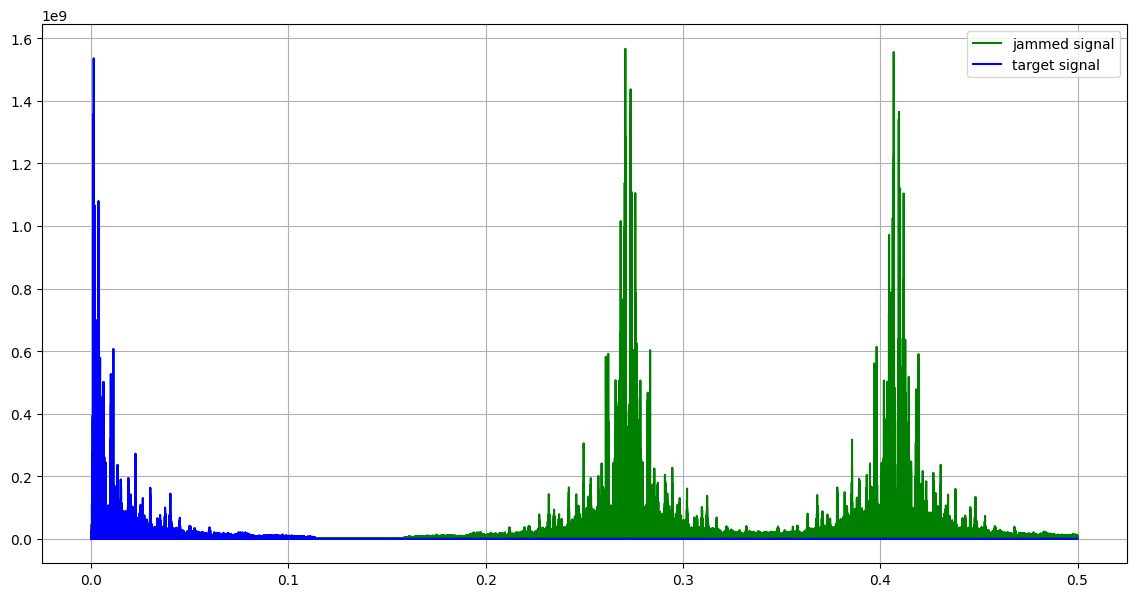

In [5]:
target_, jammed_ = create_target_and_jammed_signals(
    audio_name = 'this_is_me_trying-MONO', # 'arms_around_you-MONO',
    truncation_freq = CUT_OFF_FREQ,
    interference_center_freq = [12_000, 18_000],
    signal_partition_size = S,
    interference_scalar = 1
)

plt.figure(figsize=(14, 7))
plt.plot(*Spectrum(jammed_), 'g', label="jammed signal")
plt.plot(*Spectrum(target_), 'b', label="target signal")
plt.grid(True)
plt.legend()

In [7]:
ORDER = 4

# declare an environment with two interference center frequencies
env_with_ordinary_SNR = ReceiverEnvWithArbitaryOrderIIRandNewSNR(
    order = ORDER,
    S = S,
    cut_off_freq = CUT_OFF_FREQ,
    interference_center_freq = [12_000, 18_000],
    interference_scalar = 1,
    zero_magnitude_mapping = linear,
    gradient = None,
    fix_zeros_magnitude = False,
    automatic_gain = False,
    show_effect = False
)

creating action space with 9 dimensions...


In [8]:
NO_OF_TESTS = 4
NUM_TIME_STEPS = 4_000

reward_history_arr = []
test_reward_history_arr = [][:]
test_action_history_arr = [][:]

start = time.time()
for i in range(NO_OF_TESTS):

    # launch a DDPG agent
    keras.backend.clear_session()
    model = DDPGAgent(
        input_dims  = env_with_ordinary_SNR.observation_space.shape,
        n_actions   = env_with_ordinary_SNR.action_space.shape[0],
        alpha       = 0.0001, # learning rate of actor
        beta        = 0.001,  # learning rate of critic
        gamma       = 0.1,
        tau         = 0.001,
        critic_fc1  = 512,
        critic_fc2  = 256, #...
        actor_fc1   = 256,
        actor_fc2   = 128,
        batch_size  = 128*2,
        buffer_size = 5_000,
        noise       = 0.01, # [0.01, (0, 0.001)]
        action_activation = 'sigmoid'
    )

    # train the model
    reward_history, _ = train(model, env_with_ordinary_SNR, audio_num=1, max_num_steps=NUM_TIME_STEPS, noise_schedule=False)
    reward_history_arr.append(reward_history)
    
    # test the model
    test_reward_history, test_action_history = test(model, env_with_ordinary_SNR, audio_num=1, num_steps=NUM_TIME_STEPS)
    test_reward_history_arr.append(test_reward_history)
    test_action_history_arr.append(test_action_history)

    end = time.time()
    print("="*20 + f" execution time: {round(end - start, 4)}s " + "="*20)


--------------------------------------------------episode no: 1--------------------------------------------------
audio name: 'arms_around_you-MONO'
sampling rate: 44100 Hz
audio shape: (8631296,)
data type: int16
MONO audio file...
generating the target signal...
	truncating the spectrum at 5000Hz
	converting from float64 to <class 'numpy.int16'>; array ranges from min: -31316.608957868415 (>=-32768) to max: 31370.627685823245 (<=32767)
	trimming the audio signal...
		truncating the audio at lower 47706 and upper -33914 indices
generating the jammed signal...
	creating a non-overlapping interference signal with target spectrum shifted to 12000, 18000Hz with scales 1.0, 1.0
	converting from float64 to <class 'numpy.int32'>; array ranges from min: -49141.5184953288 (>=-2147483648) to max: 49149.0 (<=2147483647)
	converting from float64 to <class 'numpy.int32'>; array ranges from min: -81885.0 (>=-2147483648) to max: 81915.0 (<=2147483647)


/home/akila/.local/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


TypeError: SNR() got an unexpected keyword argument 'type'